### Setup

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, RichProgressBar
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBarTheme

from torchvision import transforms

from dataset import CellDataset
from model.counting_model import CSRNet
from model.twobranch import countXplain

import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
from glob import glob
import seaborn as sns

from helpers import *

In [79]:
# Initialize the model
proto_model = initialize_model(r"Saved Models/VGG/64_depth/VGG_10_proto_best.ckpt", 'VGG_CSRNet.ckpt' )
proto_model.eval()

print("Model initialized")
print(proto_model.hparams)

Model initialized
"batch_size":            1
"bg_coef":               0
"count_model":           CSRNet(
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

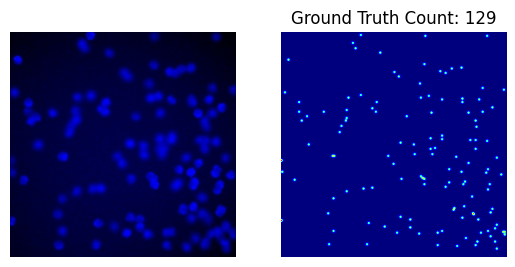

In [97]:
# Get a random image and its density map
img,dmap = get_random_image('VGG')

# convert img to BGR
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

plt.subplot(1,2,1)
plt.imshow(img,cmap='jet')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(dmap,cmap='jet')
plt.axis('off')
plt.title('Ground Truth Count: {}'.format(int(np.sum(dmap))))
plt.show()

image = apply_transforms(img)
image = image.unsqueeze(0)

In [98]:
csr = CSRNet(learning_rate=1e-5).load_from_checkpoint(r'VGG_CSRNet.ckpt')
csr.eval()

# Perform a forward pass with the image
fmaps,bg, fg, distances = proto_model(image)

similarities = proto_model.distance2similarity(distances)

print(f"Predicted count: {int(torch.sum(fg))}")

Predicted count: 114


In [72]:
all_imgs = glob("../Datasets/VGG/trainval/images/*.png")

p_values = statistical_test(all_imgs, proto_model, csr)

for i in range(len(p_values)):
    if p_values[i] < 0.01:
        print(f"Prototype {i} is statistically significant with p-value {p_values[i]}")

Calculating the Wilcoxon signed rank test for 10 prototypes


100%|██████████| 200/200 [05:42<00:00,  1.71s/it]

Prototype 0 is statistically significant with p-value 7.180732063806761e-35
Prototype 1 is statistically significant with p-value 7.180732063806761e-35
Prototype 2 is statistically significant with p-value 7.180732063806761e-35
Prototype 3 is statistically significant with p-value 7.180732063806761e-35
Prototype 4 is statistically significant with p-value 7.180732063806761e-35


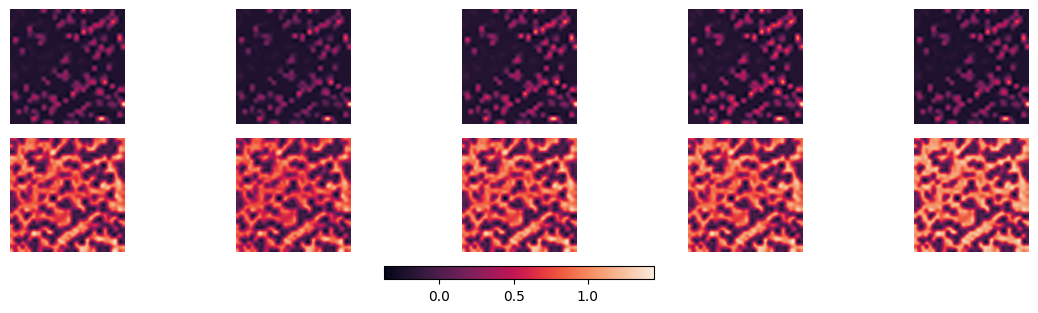

In [82]:
similarity_map(proto_model,similarities)

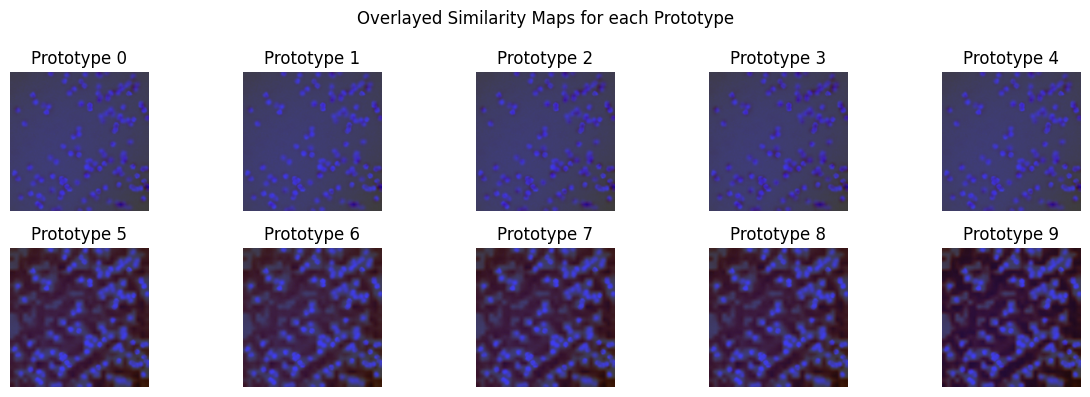

In [83]:
overlay_similarity(proto_model,img,similarities)

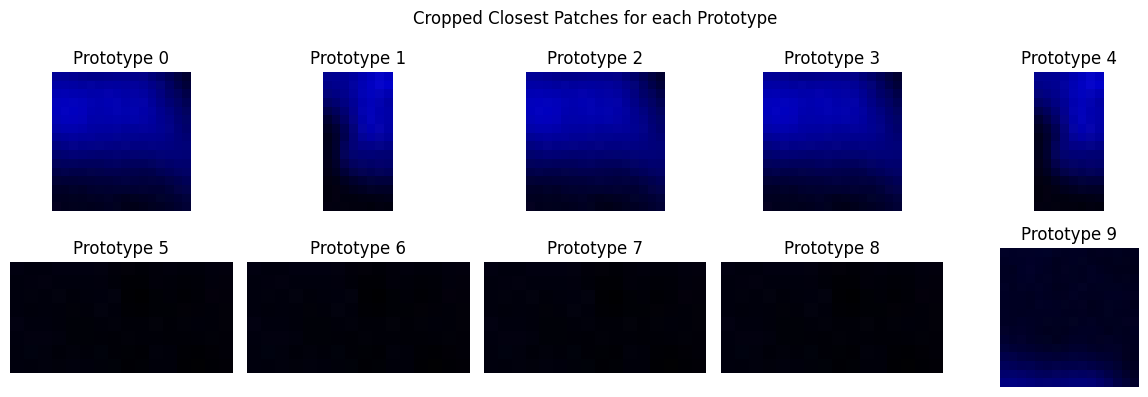

In [84]:
crop_closest(proto_model,similarities,img)

In [85]:
multiple_highly_activated(proto_model,similarities,img, percentile=99)

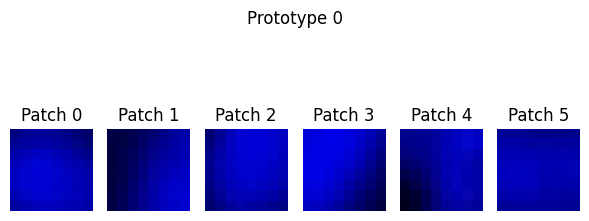

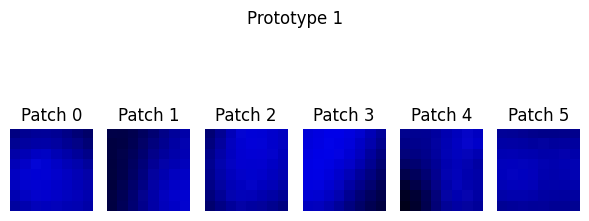

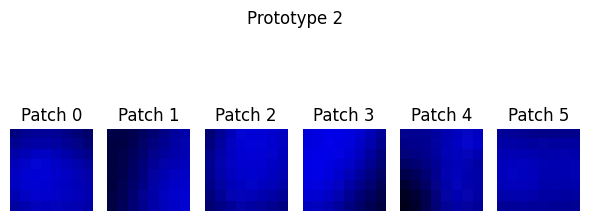

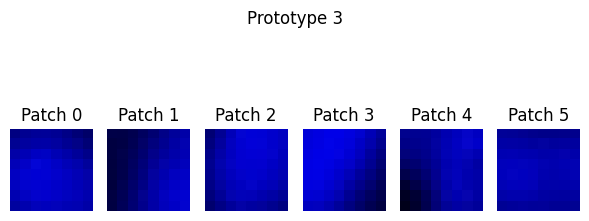

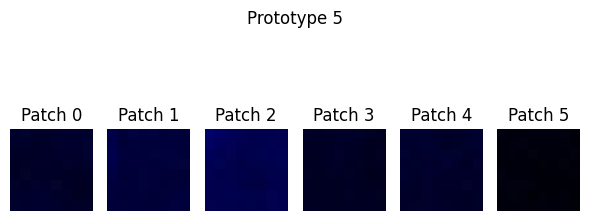

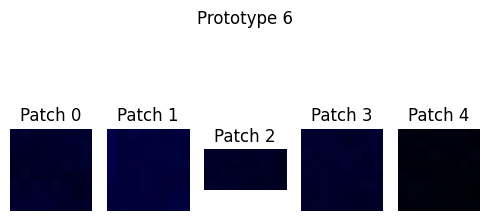

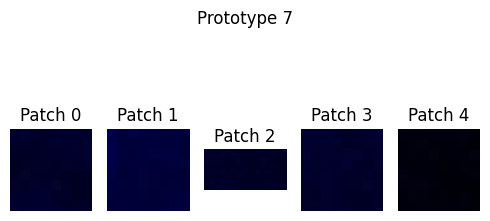

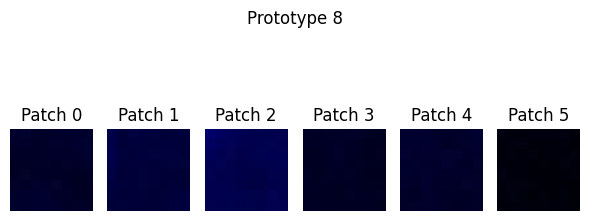

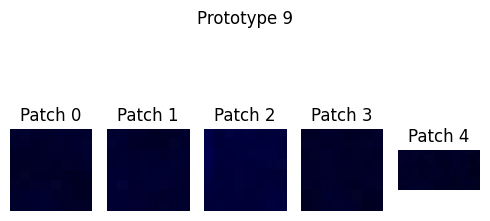

In [86]:
crop_multiple_highly_activated(proto_model,similarities,img, percentile=99.5)

In [10]:
all_imgs = glob(r'../Datasets/VGG/test/images/*.png')

p_values = wilcoxon_signed_rank_test(all_imgs,proto_model,csr)

print(f"p-value: {p_values}")

Calculating the Wilcoxon signed rank test for 20 prototypes


100%|██████████| 136/136 [07:48<00:00,  3.44s/it]

p-value: [2.2989111389025105e-24, 2.2989111389025105e-24, 2.2989111389025105e-24, 2.2989111389025105e-24, 2.2989111389025105e-24, 2.2989111389025105e-24, 2.2989111389025105e-24, 2.2989111389025105e-24, 2.2989111389025105e-24, 2.2989111389025105e-24, 4.086798379874639e-24, 4.664966863424102e-24, 2.6260574927842643e-24, 2.8065180855658394e-24, 2.8065180855658394e-24, 2.933505654166176e-24, 2.4570224413970915e-24, 2.6260574927842643e-24, 2.5684964187726322e-24, 4.3664151263166084e-24]


In [11]:
# print the indices of prototypes with p-value < 0.05
significant = [i for i in range(len(p_values)) if p_values[i] < 0.05]
print(f"Significant prototypes: {significant}")

Significant prototypes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [39]:
erased = erase_closest_patch(proto_model,similarities,img)

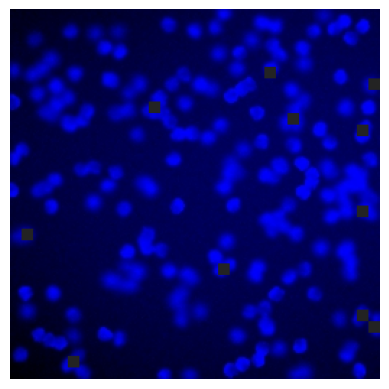

In [43]:
plt.imshow(erased[5])
plt.axis('off')
plt.show()


In [9]:
original_pred = csr(image)

print(f"Original count: {int(torch.sum(original_pred))}")

for i in erased:
    # apply transforms
    i = apply_transforms(i)
    i = i.unsqueeze(0)
    # Perform a forward pass with the image
    pred = csr(i)

    print(f"Predicted count: {int(torch.sum(pred))}")

Original count: 111
Predicted count: 108
Predicted count: 108
Predicted count: 108
Predicted count: 108
Predicted count: 108
Predicted count: 108
Predicted count: 108
Predicted count: 108
Predicted count: 108
Predicted count: 108
Predicted count: 114
Predicted count: 115
Predicted count: 116
Predicted count: 114
Predicted count: 114
Predicted count: 114
Predicted count: 117
Predicted count: 114
Predicted count: 115
Predicted count: 115


In [99]:
test_loader = proto_model.test_dataloader()


# for each image in the test set, get the predicted count and the ground truth count
preds = []
gts = []
csr_preds = []


for img, dmap in test_loader:
    # Perform a forward pass with the image
    fmaps,bg, fg, distances = proto_model(img)
    pred = int(torch.sum(fg))
    pred_csr = int(torch.sum(csr(img)))
    gt = int(torch.sum(dmap))
    preds.append(pred)
    gts.append(gt)
    csr_preds.append(pred_csr)

print(len(preds))
print(len(gts))
print(len(csr_preds))

# Calculate the mean absolute error between the predicted counts and the ground truth counts
proto_mae = np.mean(np.abs(np.array(preds) - np.array(gts)))
print(f"Proto MAE: {proto_mae}")

csr_mae = np.mean(np.abs(np.array(csr_preds) - np.array(gts)))
print(f"CSRNet MAE: {csr_mae}")

136
136
136
Proto MAE: 0.5367647058823529
CSRNet MAE: 0.4264705882352941
